Problem 1

Parameters of the largest circle:
Center: (108, 256)
Radius: 12
Range of σ values used: 0.04 to 6.4980000000000055


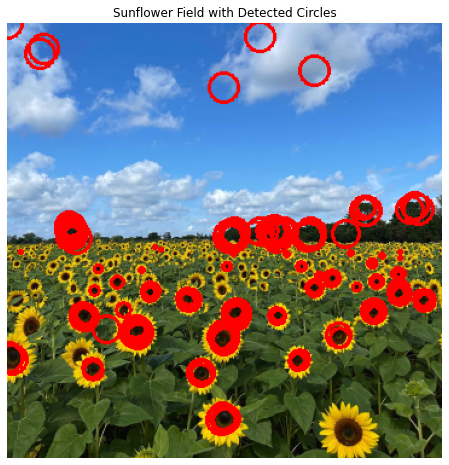

In [49]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Variables
min_radius = 0.5  # Minimum circle radius
max_radius = 500 # Maximum circle radius
sigma_values = np.arange(0.04, 6.5, 0.002)  # Range of sigma values to use

# Initialize an empty list to store detected circles
circles = []

for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    
    # Apply Laplacian of Gaussian (LoG) to find zero-crossings
    log = cv.Laplacian(blurred, cv.CV_64F)
    
    # Find the local extrema in the LoG image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(log)
    
    # Threshold the LoG image to detect extrema
    threshold = 0.175
    if max_val > threshold:
        radius = int(sigma * 2)
        
        if min_radius <= radius <= max_radius:
            circles.append((max_loc[0], max_loc[1], radius))

circles.sort(key=lambda x: x[2], reverse=True)

largest_circle = circles[0]
center_x, center_y, radius = largest_circle

print("Parameters of the largest circle:")
print(f"Center: ({center_x}, {center_y})")
print(f"Radius: {radius}")
print(f"Range of σ values used: {sigma_values[0]} to {sigma_values[-1]}")


im_with_circles = im_rgb.copy()
# Draw circles on the copy of the image
for circle in circles:
    center_x, center_y, radius = circle
    cv.circle(im_with_circles, (center_x, center_y), radius, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(im_with_circles)
plt.title("Sunflower Field with Detected Circles")
plt.axis("off")
plt.show()

Problem 2

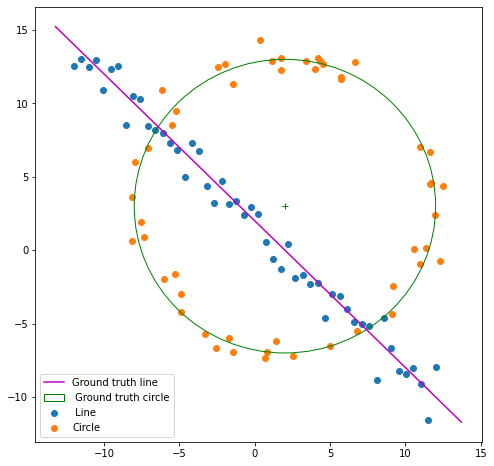

In [21]:
# Given data

# Generation o f a Noisy Po in t Set Conforming to a Line and a Circle
import numpy as np
#from scipy . optimize import minimize
#from scipy import linalg
import matplotlib . pyplot as plt
#import tikzplotlib

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16

t = np.random.uniform (0 ,2*np.pi,half_n)

n = s*np.random.randn( half_n )

x,y = x0_gt + (r + n)*np.cos(t) , y0_gt + (r + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n , 1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 )))
X = np.vstack ( ( X_circ , X_line ) ) # All points


# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
plt . legend ()

In [23]:
import numpy as np

def line_ransac(points, distance_threshold, max_iterations=10000):
    best_line = None
    best_inliers_idx = []
    
    for _ in range(max_iterations):
        # Randomly select two points to define a line
        sample_indices = np.random.choice(len(points), size=2, replace=False)
        sample = points[sample_indices]
        
        # Calculate the unit normal vector to the line
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        
        if x1 == x2:
            continue  # Avoid division by zero
        
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init = np.abs(np.dot(unit_normal_vector, sample[0]))
        
        # Calculate the perpendicular distance from the origin to the line
        perpendicular_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in points]
        
        # Find inliers based on the distance threshold
        inliers_idx = [i for i, distance in enumerate(perpendicular_distances) if np.abs(distance - d_init) < distance_threshold]
        
        # Update the best model if this one has more inliers
        if len(inliers_idx) > len(best_inliers_idx):
            best_line = (unit_normal_vector, d_init)
            best_inliers_idx = inliers_idx
            
    best_fitting_points = points[best_inliers_idx]
    
    return best_line, best_inliers_idx, best_fitting_points


In [26]:
import numpy as np

def circle_residuals(params, points):
    h, k, r = params
    residuals = [(x - h)**2 + (y - k)**2 - r**2 for x, y in points]
    return np.array(residuals)

def circle_ransac(points, radial_distance_threshold):
    max_iterations = 10000
    best_circle = None
    best_inliers_index = []
    
    for _ in range(max_iterations):
        # Randomly select three points to define a circle
        sample_indices = np.random.choice(len(points), size=3, replace=False)
        sample = points[sample_indices]
        
        # Calculate the center and radius of the estimated circle without optimization
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        x3, y3 = sample[2]
        
        D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
        h_opt = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
        k_opt = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
        r_opt = np.sqrt((x1 - h_opt)**2 + (y1 - k_opt)**2)
        
        # Calculate the radial distance from the points to the estimated circle
        radial_distances = [np.abs(np.sqrt((x - h_opt)**2 + (y - k_opt)**2) - r_opt) for x, y in points]
        
        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(radial_distances) if distance < radial_distance_threshold]
        
        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_circle = (np.array([h_opt, k_opt]), r_opt)
            best_inliers_index = inliers_index
            best_fitting_points = sample
            
    return best_circle, best_inliers_index, best_fitting_points


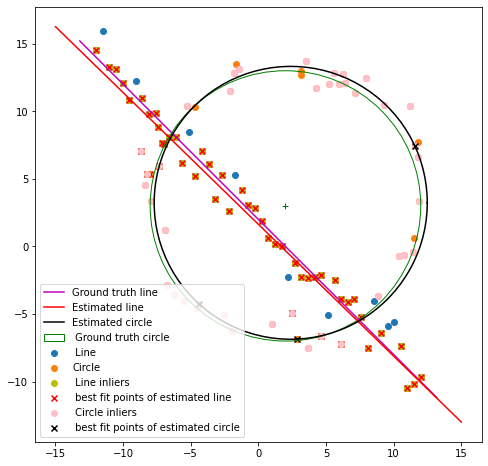

In [28]:

# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16

t = np.random.uniform (0 ,2*np.pi,half_n)

n = s*np.random.randn( half_n )

x,y = x0_gt + (r + n)*np.cos(t) , y0_gt + (r + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1) ,y.reshape(half_n , 1)))

s = 1.
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 )))
X = np.vstack ( ( X_circ , X_line ) ) # All points

#estimated line
estimated_line, inliers_index_line,best_fit_points_line = line_ransac(X,1)
x_val = np.linspace(-15, 15, 100)

# calculate the y values of the estimated line
m_est = -estimated_line[0][0] / estimated_line[0][1]
b_est = estimated_line[1] / np.cos(np.arctan(abs(m_est)))
y_val = m_est*x_val + b_est
#estimated circle
points_circle = X.copy()

# remove the inliers of the line from points_circle
points_circle = np.delete(points_circle, inliers_index_line, axis=0)

estimated_circle, inliers_index_circle,best_fit_points_circle = circle_ransac(points_circle,1)
theta = np.linspace(0, 2*np.pi, 100)
x_val_circle = estimated_circle[0][0] + estimated_circle[1]*np.cos(theta)
y_val_circle = estimated_circle[0][1] + estimated_circle[1]*np.sin(theta)



# Plotting
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] , label= ' Line'  )
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
circle_gt = plt.Circle(( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= ' Ground truth circle')
ax . add_patch ( circle_gt )
ax.plot((x0_gt) , (y0_gt) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim ()
x_ = np.array([x_min,x_max])
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line')
ax . scatter ( X[inliers_index_line][:,0] , X[inliers_index_line][:,1] , color = 'y',label= ' Line inliers'  )
ax . scatter ( np.array(best_fit_points_line)[:,0] , np.array(best_fit_points_line)[:,1] ,marker = 'x', color = 'r',label= ' best fit points of estimated line'  )
ax.plot(x_val, y_val, color='r', label='Estimated line')
ax . scatter ( X[inliers_index_circle][:,0] , X[inliers_index_circle][:,1] , color = 'pink',label= ' Circle inliers'  )
ax . scatter ( np.array(best_fit_points_circle)[:,0] , np.array(best_fit_points_circle)[:,1] , marker = 'x',color = 'k',label= ' best fit points of estimated circle'  )
ax.plot(x_val_circle, y_val_circle, color='k', label='Estimated circle')
plt . legend ()

Problem 03

H=  [[ 2.69205002e+00 -6.92363958e-03  4.59000000e+02]
 [ 1.20325886e-01  2.93051232e+00  5.00000000e+01]
 [ 5.34830208e-04  1.94075487e-06  1.00000000e+00]]


Text(0.5, 1.0, 'Overlayed Image')

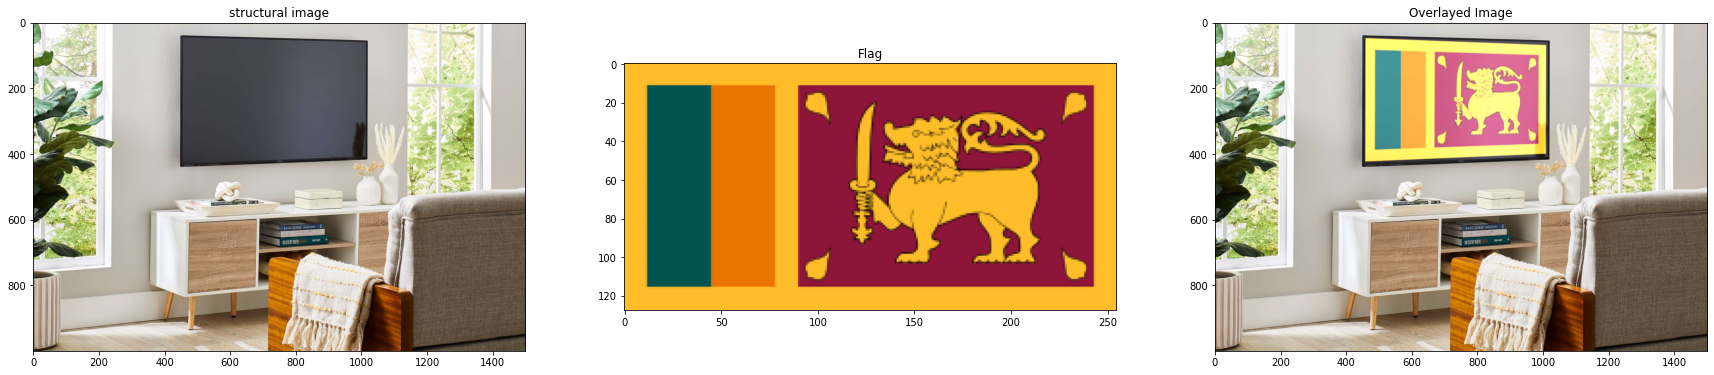

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

k = 0
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])


def Homography(imgPoints, flagPoints):
    A = []
    for i in range(4):
        A.append([flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],0,0,0,
        -imgPoints[i][0]*flagPoints[i][0],-imgPoints[i][0]*flagPoints[i][1],-imgPoints[i][0]*flagPoints[i][2]])
        A.append([0,0,0,flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],
        -imgPoints[i][1]*flagPoints[i][0],-imgPoints[i][1]*flagPoints[i][1],-imgPoints[i][1]*flagPoints[i][2]])
    A = np.array(A,dtype = np.float64)
    AAT = A.T @ A
    w, v = np.linalg.eig(AAT)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H

img = cv.imread('tv1.jpg',cv.IMREAD_ANYCOLOR)
cv.imshow("IMG",img)
imgPoints = []
cv.setMouseCallback("IMG",mousePoint)
k = cv.waitKey(0)
if k ==ord('q'): 
    cv.destroyAllWindows()


imgFlag = cv.imread('sl.png',cv.IMREAD_ANYCOLOR)
flagheight,flagWidth = imgFlag.shape[0],imgFlag.shape[1]
flagPoints = np.array([[0,0,1],[flagWidth,0,1],[flagWidth,flagheight,1],[0,flagheight,1]])
imgPoints = np.array(imgPoints)
H = Homography(imgPoints,flagPoints)

rows,cols,ch = img.shape
warpedImg = cv.warpPerspective(imgFlag,H,(cols,rows))
overlayImg = cv.add(img, warpedImg)
fig,ax = plt.subplots(1,3,figsize = (30,15))
warpedImg = cv.cvtColor(warpedImg, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgFlag = cv.cvtColor(imgFlag, cv.COLOR_BGR2RGB)
overlayImg = cv.cvtColor(overlayImg, cv.COLOR_BGR2RGB)

ax[0].imshow(img)
ax[0].set_title("structural image")
ax[1].imshow(imgFlag)
ax[1].set_title("Flag")
ax[2].imshow(overlayImg)
ax[2].set_title("Overlayed Image")

Problem 4

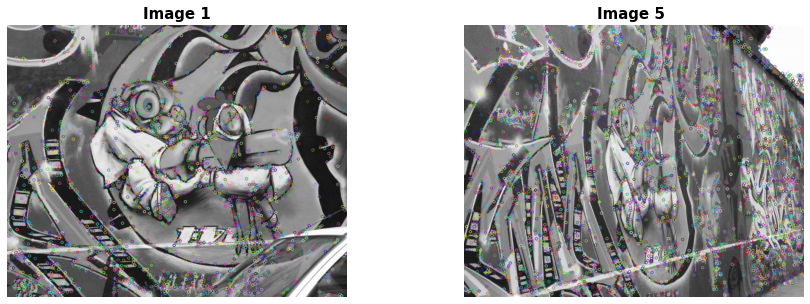

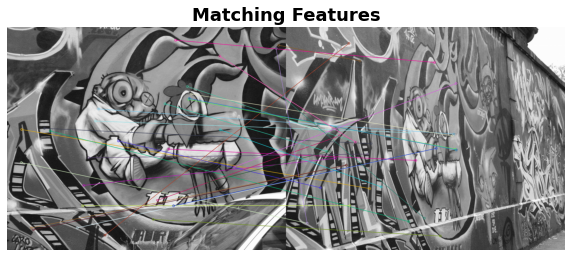

In [5]:
im1 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img1.ppm", cv.IMREAD_GRAYSCALE)
im5 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img5.ppm", cv.IMREAD_GRAYSCALE)


# Create a SIFT object
sift = cv.SIFT_create()

# Detect and compute keypoints and descriptors for both images
kp1, descs1 = sift.detectAndCompute(im1, None)
kp2, descs2 = sift.detectAndCompute(im5, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)

# Create a FLANN matcher
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descs1, descs2, k=2)

# Apply ratio test to get good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw good matches on a new image
im3 = cv.drawMatches(im1, kp1, im5, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Create images with keypoints drawn
kp_im_1 = cv.drawKeypoints(im1, kp1, None)
kp_im_5 = cv.drawKeypoints(im5, kp2, None)

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv.cvtColor(kp_im_1, cv.COLOR_BGR2RGB))
ax[0].set_title("Image 1", fontweight="bold", fontsize=15)
ax[0].axis("off")

ax[1].imshow(cv.cvtColor(kp_im_5, cv.COLOR_BGR2RGB))
ax[1].set_title("Image 5 ", fontweight="bold", fontsize=15)
ax[1].axis("off")
plt.show()

# Display the matching features
fig = plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(im3, cv.COLOR_BGR2RGB))
plt.title("Matching Features", fontweight="bold", fontsize=18)
plt.axis('off')
plt.show()


In [35]:
def randN(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return randN(n,t)

def compute_Homography(from_Pt, to_Pt):
    
    X1, Y1, X2, Y2, X3, Y3, X4, Y4 = to_Pt[0], to_Pt[1], to_Pt[2], to_Pt[3], to_Pt[4], to_Pt[5], to_Pt[6], to_Pt[7]
    X1T, X2T, X3T, X4T = from_Pt[0], from_Pt[1], from_Pt[2], from_Pt[3]
    z_mat = np.array([[0],[0],[0]])
    
    m = np.concatenate((z_mat.T,X1T, -Y1*X1T), axis=1)
    n = np.concatenate((X1T,z_mat.T, -X1*X1T), axis=1)

    o = np.concatenate((z_mat.T,X2T, -Y2*X2T), axis=1)
    p = np.concatenate((X2T,z_mat.T, -X2*X2T), axis=1)

    q = np.concatenate((z_mat.T,X3T, -Y3*X3T), axis=1)
    r = np.concatenate((X3T,z_mat.T, -X3*X3T), axis=1)

    s = np.concatenate((z_mat.T,X4T, -Y4*X4T), axis=1)
    t = np.concatenate((X4T,z_mat.T, -X4*X4T), axis=1)

    A = np.concatenate((m,n,o,p,q,r,s,t), axis=0)
    W,V = np.linalg.eig((A.T)@A)
    temp = V[:, np.argmin(W)]
    K = temp.reshape((3,3))
    return K

im2 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img2.ppm")
im3 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img3.ppm")
im4 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img4.ppm")

images = [im1, im2, im3, im4, im5]

In [32]:
g, h = 0.99, 0.5
N = int(np.ceil(np.log(1-g)/np.log(1-((1-h)**4))))

H = []
for t in range(4):
    sift = cv.SIFT_create()
    kp1, decs1= sift.detectAndCompute(images[t],None)
    kp2, decs2 = sift.detectAndCompute(images[t+1],None)

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

    matches = bf.match(decs1,decs2)
    matches = sorted(matches, key = lambda x:x.distance)

    lst_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    lst_kp2 = [kp2[mat.trainIdx].pt for mat in matches]

    t_h, I, b_H = 2, 0, 0

    for k in range(N):
        rand_pts = randN(len(lst_kp1)-1,4)

        from_Pt = []
        for i in range(4):
            from_Pt.append(np.array([[lst_kp1[rand_pts[i]][0], lst_kp1[rand_pts[i]][1], 1]]))

        to_Pt = []
        for j in range(4): 
            to_Pt.append(lst_kp2[rand_pts[j]][0])
            to_Pt.append(lst_kp2[rand_pts[j]][1])
        
        inliers = 0
        for i in range(len(lst_kp1)):
            X = [lst_kp1[i][0], lst_kp1[i][1], 1]
            hX = compute_Homography(from_Pt, to_Pt)@X
            hX /= hX[-1]
            error = np.sqrt(np.power(hX[0]-lst_kp2[i][0],2) + np.power(hX[1]-lst_kp2[i][1],2))
            if error < t_h: inliers+=1
        
        if inliers > I:
            I = inliers
            b_H = compute_Homography(from_Pt, to_Pt)

    H.append(b_H)

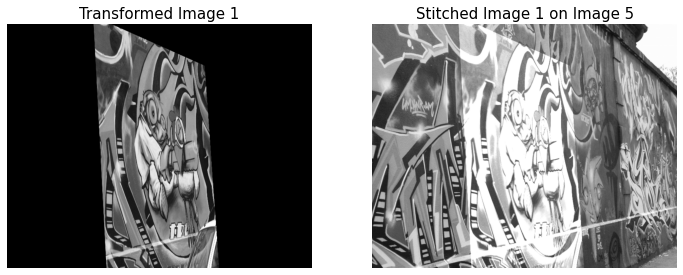

In [50]:
H_1_to_5 = H[3] @ H[2] @ H[1] @ H[0]
H_1_to_5 /= H_1_to_5[-1][-1]

trans = cv.warpPerspective(im1, H_1_to_5 ,(np.shape(im5)[1] ,np.shape(im5)[0]))

fig, ax = plt.subplots(1,2,figsize=(12,12))

#plotting the outputs
ax[0].imshow(cv.cvtColor(trans, cv.COLOR_BGR2RGB))
ax[0].set_title("Transformed Image 1",fontsize = 15)
ax[0].axis("off")

output = cv.add(im5,trans)
ax[1].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image 1 on Image 5",fontsize = 15)
ax[1].axis("off")
plt.show()